# Approximation for Exotic Call


## PART 0: Introduction of the option

The payoff of European option at expiration date is:
#### $$Above Strike:  w_1  * (S_T-K )$$
#### $$Below Strike:  w_2  * (S_T-K )$$


where $S_T $ is the spot price at maturity, $K$ is the strike price, $w_1$ is weight (above strike, positive, gain),$w_2$ is weight(below strike,negative, loss)

## Price Paths
-GBM path

In [1]:
import datetime
import numpy as np
import scipy.stats as ss
import numpy.polynomial as nppoly
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(1234) # seed

In [3]:
def  gen_paths (S0, r, sigma, T, M, I):
    ''' Generate Monte Carlo paths for geometric Brownian motion.
    
    Parameters
    ==========
    S0 : float
        initial stock/index value
    r : float
        constant short rate
    sigma : float
        constant volatility
    T : float
        final time horizon
    M : int
        number of time steps/intervals
    I : int
        number of paths to be simulated
        
    Returns
    =======
    paths : ndarray, shape (M + 1, I)
        simulated paths given the parameters
    '''
    dt = float(T) / M
    paths = np.zeros((M + 1, I), np.float64)
    paths[0] = S0
    for t in range(1, M + 1):
        rand = np.random.standard_normal(I)
        rand = (rand - rand.mean()) / rand.std()
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * rand)
    return paths

### Assumptions

In [4]:
S = 600 # Underlying price
sigma = 0.2 # vol
r = 0.01 # risk free rate
T = 1 # time to maturity
K = 580 # strike
w_1 = 0.5 # weight-above strike
w_2 = 0.5 # weight-below strike
n = 10000 # no. of simulation
M = 200 # no. of time step

In [5]:
paths = gen_paths(S, r, sigma, T, M, n)

### Simulated Price Paths

In [6]:
sns.set(rc = {"figure.figsize":(10,8)})
sns.set_palette(sns.color_palette("Set1"))

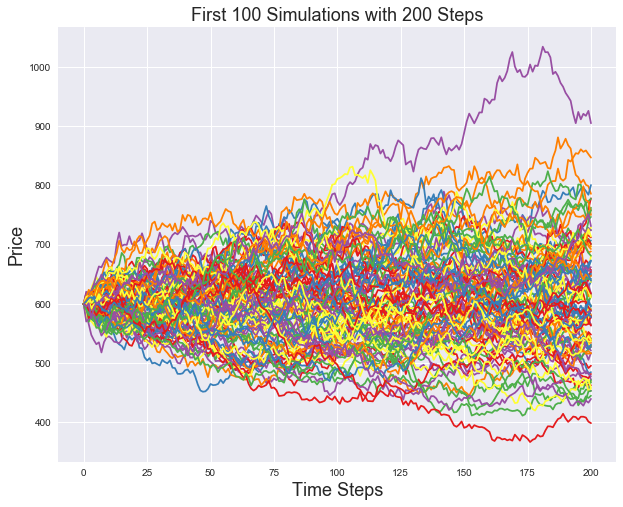

In [7]:
plt.plot(paths[:, :100])
plt.grid(True)
plt.title(' First %d Simulations with %d Steps ' %(100,M),fontsize =18)
plt.xlabel('Time Steps',fontsize =18)
plt.ylabel('Price',fontsize =18)
plt.show()
# tag: mc price
# title: First 1000 simulated paths of Geometric Brownian Motion

## MC  & Variance Reduction ##
varaince reduction-improve the accuracy and convergene rate of MC without increasing the sample number

In [8]:
#Calculates exactly and estimates Black-Scholes options prices.
def EOptionPrice(S, K, r, sigma, T, n, m,w_1,w_2):
    np.random.seed(1234) # seed

    #Calculate options price.
    def CalcPrice(S, K, r, sigma, T):
        """Direct Black(1976)Calculation"""

        d_1 = (1/(sigma*np.sqrt(T)))*((np.log(S/K)) + ( 0.5*sigma**2)*T)
        d_2 = d_1 - sigma*np.sqrt(T)

        callPrice = (ss.norm.cdf(d_1)*S - ss.norm.cdf(d_2)*K) *np.exp(-r*T) #Black(1976) call price.
        #putPrice = np.exp(-r*T)*K - S + callPrice #Black-scholes put price, determined by put-call parity.

        return callPrice

    def EstPriceMC(S, K, r, sigma, T, n,w_1,w_2):
        """ Standard Monte Carlo """      

        N = np.random.normal(loc = 0, scale = 1, size = n) #Generate n normal random numbers mean 0, variance 1.
        S_T = S*np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*N) #Generate n terminal stock prices from n random numbers U, U ~ N[0,1]. GBM
        DF = (np.exp(-r*T)) #Discount factor

        callPayoffMC = np.where(S_T < K, w_2 * (S_T-K), w_1 * (S_T-K)) #Where S_t is less than K, make it w_2*(S_T-K), otherwise make it w_1*(S_T - K).

        callPriceMC = DF*np.mean(callPayoffMC)
        VARcallPriceMC = DF*np.std(callPayoffMC)/np.sqrt(n)

        return callPriceMC, VARcallPriceMC

    def EstPriceMC_AV(S, K, r, sigma, T, n,w_1,w_2):
        """ Antithetic variates """

        DF = (np.exp(-r*T)) #Discount factor
        N = np.random.normal(loc = 0, scale = 1, size = n) #Generate n normal random variables, mean 0, variance 1.
        S_T_1 = S*np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*N) #Generate n terminal stock prices from n random numbers N, N ~ N[0,1]. 
        S_T_2 = S*np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*-N) #Generate n terminal stock prices from n random numbers N, N ~ N[0,1]. 

        callPayoffMC_1 = np.where(S_T_1 < K, w_2 * (S_T_1-K), w_1 * (S_T_1-K)) 
        callPayoffMC_2 = np.where(S_T_2 < K, w_2 * (S_T_2-K), w_1 * (S_T_2-K))
 
        callPriceMC_AV = DF*np.mean(0.5*(callPayoffMC_1 + callPayoffMC_2)) #Call price is average of both parts.
        VARcallPriceMC_AV = DF*np.std(0.5*(callPayoffMC_1 + callPayoffMC_2))/np.sqrt(n)

 
        return callPriceMC_AV, VARcallPriceMC_AV

    def EstPriceMC_IS(S, K, r, sigma, T, n,w_1,w_2):
        """ Importance Sampling """

        DF = (np.exp(-r*T)) #Discount factor
        theta = -0.1 #Works best for negatvie values
        N = np.random.normal(loc = 0, scale = 1, size = n) #Generate n normal random variables, mean 0, variance 1.
        S_T = S*np.exp(((r + theta*sigma) - 0.5*sigma**2)*T + sigma*np.sqrt(T)*N)
        LR = np.exp(-theta*N - 0.5*T*theta**2) #Likelihood ratio

        callPayoffMC_IS = (np.where(S_T < K, w_2 * (S_T-K), w_1 * (S_T-K)))*LR

        callPriceMC_IS = DF*np.mean(callPayoffMC_IS)
        VARcallPriceMC_IS = DF*np.std(callPayoffMC_IS)/np.sqrt(n)       

        return callPriceMC_IS, VARcallPriceMC_IS

    def EstPriceMC_SS(S, K, r, sigma, T, n, m,w_1,w_2):
        """ Stratified Sampling """

        DF = (np.exp(-r*T)) #Discount factor
        grid = np.mgrid[0:1:1/n, 0:1:1/m]#Set up stratification (first digit defining each stratum).

        U = np.random.uniform(0, 1, (n, m)) #Generate nxm U, U~Unif[0,1].
        U_strat = grid + U/n #Create U stratified. Add random numbers in, normalised by the grid size.
        N_strat = ss.norm.ppf(U_strat) #Make U normally distibuted by applying inverse normal CDF.
        S_T = S*np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*N_strat) #Generate n terminal stock prices from n random numbers U, U ~ N[0,1].

        callPayoffMC_SS = np.where(S_T < K, w_2 * (S_T-K), w_1 * (S_T-K))
        
        callPriceMC_SS = DF*np.mean(callPayoffMC_SS) #Set row axis, as each row is a strata.
        VARcallPriceMC_SS = DF*np.std(callPayoffMC_SS)/np.sqrt(n)

        return callPriceMC_SS, VARcallPriceMC_SS

    #Call nested functions
    callPrice = CalcPrice(S, K, r, sigma, T)
    callPriceMC, VARcallPriceMC = EstPriceMC(S, K, r, sigma, T, n,w_1,w_2)
    callPriceMC_AV,  VARcallPriceMC_AV = EstPriceMC_AV(S, K, r, sigma, T, n,w_1,w_2)
    callPriceMC_IS,  VARcallPriceMC_IS = EstPriceMC_IS(S, K, r, sigma, T, n,w_1,w_2)
    callPriceMC_SS, VARcallPriceMC_SS = EstPriceMC_SS(S, K, r, sigma, T, n, m,w_1,w_2)


    #Calculate variance improvements over standard Monte Carlo.
    CallVarReduc_AV = (VARcallPriceMC - VARcallPriceMC_AV)/VARcallPriceMC

    CallVarReduc_IS = (VARcallPriceMC - VARcallPriceMC_IS)/VARcallPriceMC

    CallVarReduc_SS = (VARcallPriceMC - VARcallPriceMC_SS)/VARcallPriceMC

    #Print prices info.
    print("---------------Calculated---------------")
    print(" Black(1976) Call price: ", callPrice, "\n")

    print("---------------MC Simulation---------------")
    print(" Call price estimate: ", callPriceMC, "\n")

    print("---------------MC Antithetic Variates Simulation---------------")
    print(" Call price estimate: ", callPriceMC_AV, "\n")

    print("---------------MC Importance Sampling Simulation---------------")
    print(" Call price estimate: ", callPriceMC_IS, "\n")
    
    print("---------------MC Stratified Sampling Simulation---------------")
    print(" Call price estimate: ", callPriceMC_SS, "\n")
    
    return callPrice,callPriceMC,callPriceMC_AV,callPriceMC_IS,callPriceMC_SS


In [9]:
EOptionPrice(S, K, r, sigma, T, n, 10000,w_1,w_2)

---------------Calculated---------------
 Black(1976) Call price:  57.09428371592433 

---------------MC Simulation---------------
 Call price estimate:  13.777515547168814 

---------------MC Antithetic Variates Simulation---------------
 Call price estimate:  12.814662328130524 

---------------MC Importance Sampling Simulation---------------
 Call price estimate:  13.042482184472261 

---------------MC Stratified Sampling Simulation---------------
 Call price estimate:  12.885488826092734 



(57.09428371592433,
 13.777515547168814,
 12.814662328130524,
 13.042482184472261,
 12.885488826092734)

## Scenario 1(Changing weight) ##

In [10]:
def EstPriceMC(S, K, r, sigma, T, n,w_1,w_2):
    """ Standard Monte Carlo """      
    np.random.seed(1234) # seed
    
    N = np.random.normal(loc = 0, scale = 1, size = n) #Generate n normal random numbers mean 0, variance 1.
    S_T = S*np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*N) #Generate n terminal stock prices from n random numbers U, U ~ N[0,1]. GBM
    DF = (np.exp(-r*T)) #Discount factor

    callPayoffMC = np.where(S_T < K, w_2 * (S_T-K), w_1 * (S_T-K)) #Where S_t is less than K, make it w_2*(S_T-K), otherwise make it w_1*(S_T - K).

    callPriceMC = DF*np.mean(callPayoffMC)

    return callPriceMC

In [11]:
weight_1 = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
result = np.zeros(len(weight_1))
for i in np.arange(len(weight_1)):
    result[i] = EstPriceMC(S, K, r, sigma, T,n,weight_1[i],w_2)
    print(' Weight_1 %0.4f  Price %0.4f  '%(weight_1[i],result[i]))

 Weight_1 0.0000  Price -17.0650  
 Weight_1 0.1000  Price -10.8965  
 Weight_1 0.2000  Price -4.7280  
 Weight_1 0.3000  Price 1.4405  
 Weight_1 0.4000  Price 7.6090  
 Weight_1 0.5000  Price 13.7775  
 Weight_1 0.6000  Price 19.9460  
 Weight_1 0.7000  Price 26.1145  
 Weight_1 0.8000  Price 32.2830  
 Weight_1 0.9000  Price 38.4515  
 Weight_1 1.0000  Price 44.6200  


## Greeks ##

In [12]:
ds = 0.01

In [13]:
def delta(S, K, r, sigma, T, n,w_1,w_2):
    delta =  (EstPriceMC(S+ds, K, r, sigma, T, n,w_1,w_2)-EstPriceMC(S-ds, K, r, sigma, T, n,w_1,w_2))/(2*ds)
    return delta

def gamma(S, K, r, sigma, T, n,w_1,w_2):
    gamma = (EstPriceMC(S + ds, K, r, sigma, T, n, w_1, w_2) - \
             2 * EstPriceMC(S, K, r, sigma, T, n, w_1, w_2) + \
             EstPriceMC(S - ds, K, r, sigma, T, n, w_1, w_2))/(ds**2)

    return gamma

def vega(S, K, r, sigma, T, n,w_1,w_2):
    vega = (EstPriceMC(S, K, r, sigma+0.01, T, n,w_1,w_2)-EstPriceMC(S, K, r, sigma-0.01, T, n,w_1,w_2))/2
    return vega

def rho(S, K, r, sigma, T, n,w_1,w_2):
    rho = (EstPriceMC(S, K, r+0.01, sigma, T, n,w_1,w_2)-EstPriceMC(S, K, r-0.01, sigma, T, n,w_1,w_2))/2
    return rho

def theta(S, K, r, sigma, T, n,w_1,w_2):
    if T<=1/365:
        theta = EstPriceMC(S, K, r, sigma, 0.000001, n,w_1,w_2)-EstPriceMC(S, K, r, sigma, T, n,w_1,w_2)
    else:
        theta = EstPriceMC(S, K, r, sigma, T-1/365, n,w_1,w_2)-EstPriceMC(S, K, r, sigma, T, n,w_1,w_2)
    return theta

In [14]:
call_price = EstPriceMC(S, K, r, sigma, T, n,w_1,w_2)
call_delta = delta(S, K, r, sigma, T, n,w_1,w_2)
call_gamma = gamma(S, K, r, sigma, T, n,w_1,w_2)
call_vega = vega(S, K, r, sigma, T, n,w_1,w_2)
call_rho = rho(S, K, r, sigma, T, n,w_1,w_2)
call_theta = theta(S, K, r, sigma, T, n,w_1,w_2)

In [15]:
print("---------------Price---------------")
print(" price: ", call_price)
print("---------------Greeks---------------")
print(" delta: ", call_delta, "\n"
           " vega: ", call_vega, "\n",
           "gamma: ", call_gamma, "\n",
           "rho: ", call_rho, "\n",
           "theta: ", call_theta, "\n")

---------------Price---------------
 price:  13.777515547168814
---------------Greeks---------------
 delta:  0.501486612223534 
 vega:  0.039760336097006466 
 gamma:  1.7763568394002505e-11 
 rho:  2.8711923705204816 
 theta:  -0.008956637501867704 

